# Amazon Copurchased

This is a Python notebook created using "jupyter".

Author: Rafael J. P. dos Santos

## Condições do experimento

-

## Parameters

We use the parameter below to set the maximum number of edges to be read from the CSV containing edges (links).

In [1]:
max_edges = 50000 # Set quantity to read from file
edges_csv_file = "data/20180812_links"
nodes_csv_file = "data/20180812_nodes"

## Load the libraries

Let's load the Python libraries that we will need throughout the script

In [2]:
%load_ext autoreload
%autoreload 1
%aimport shared_functions
import pandas as pd
import numpy as np
from __future__ import division
import shared_functions
from IPython.display import display, HTML

## Read graph

### Read only first lines of datafile

Due to slowness in calculating centrality measures, we use the parameter provided in the beggining of the script to limit the number of edges we will read.

In [3]:
G = shared_functions.read_G(edges_csv_file, max_edges)

Using 50000 edges out of 229338 available (21.80% of data)


### Calculate nodes centrality measures

Now that we have our NetworkX graph, let's calculate some centrality measures for every node.

In [4]:
centrality_measures = shared_functions.centrality_measures(G)
print centrality_measures.keys()

['eigenvector_centrality', 'degree', 'betweenness_centrality']


### Load node properties

Let's load the CSV containing the nodes data (title, price) into a Pandas dataframe, and append the centrality measures calculated above.

In [5]:
df = pd.read_csv(nodes_csv_file)

####  Convert ID to random int to avoid leaking knowledge

In [6]:
df = shared_functions.add_sha256_column_from_id(df)

#### Add centrality measures

In [7]:
df = shared_functions.merge_columns(df, centrality_measures)

### Let's convert some fields to numeric

In [8]:
categorical_features = [
    'category1',
    'category2',
    'category3',
    'category4',
    'category5',
    'category6',
    'category7',
    'category8',
    'category9',
    'category10',
    'language',
    'coverType',
    'publisher',
    'rankingCategory',
    'authors'
]

numeric_features = [
    #'degree',
    #'eigenvector_centrality',
    #'betweenness_centrality',
    'ranking',
    'reviewCount',
    'pages',
    'weight',
    'height',
    'width',
    'depth',
    'rating'
]

df = shared_functions.prepare_data(df, numeric_features)

### Remove nodes without price

In [9]:
df = df.drop(df[df["price"].isnull()].index)

### Inspect columns

In [10]:
df.columns

Index([u'id', u'title', u'url', u'authors', u'coverType', u'publisher',
       u'edition', u'publicationDate', u'rankingCategory', u'category1',
       u'category2', u'category3', u'category4', u'category5', u'category6',
       u'category7', u'category8', u'category9', u'category10', u'isbn10',
       u'isbn13', u'language', u'postProcessed', u'price', u'ranking',
       u'pages', u'reviewCount', u'rating', u'width', u'height', u'depth',
       u'weight', u'sha256_id', u'eigenvector_centrality', u'degree',
       u'betweenness_centrality'],
      dtype='object')

### Features summary

Below we have a summary of the Pandas dataframe. We can see the number of nodes that we are actually analyzing, which depends on the max_edges parameter defined before.

In [11]:
pd.set_option('display.max_columns', None)
df.describe(include='all', percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99])

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,sha256_id,eigenvector_centrality,degree,betweenness_centrality
count,8027.000000,8027,8027,8026,7942,7955,0.0,647,7738,7638,7638,5736,2914,1039,160,12,0.0,0.0,0.0,7958,7958,7953,8027.0,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8.027000e+03,8.027000e+03,8027.000000,8027.000000
unique,NaN,7843,8027,5423,11,650,NaN,493,1,1,28,219,419,275,63,6,NaN,NaN,NaN,7958,7958,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Macroeconomia,https://www.amazon.com.br/dp/8580332990/,Vários Autores (Autor),Capa comum,Companhia das Letras,NaN,1 de janeiro de 2014,Livros,Livros,"Política, Filosofia e Ciências Sociais",Filosofia,Matemática,Faculdade,Probabilidade e Estatística,Neurociência,NaN,NaN,NaN,8525431494,978-8582600481,Português,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,6,1,88,6767,489,NaN,11,7738,7638,1389,832,149,68,16,3,NaN,NaN,NaN,1,1,7033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4725.990034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,73.122549,34228.329969,356.933745,14.912043,4.447393,15.251210,22.242428,2.096651,426.744255,2.117269e+09,3.115231e-03,10.453096,0.001092
std,2836.414933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,149.003550,46848.320947,253.929503,34.309014,0.554086,2.558094,2.571012,1.217930,202.054929,1.239365e+09,1.061049e-02,22.681994,0.003178
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.900000,3.000000,2.000000,1.000000,1.000000,0.800000,8.600000,0.200000,4.500000,2.291770e+05,3.296592e-09,1.000000,0.000000
25%,2290.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,26.585000,7611.500000,200.000000,2.000000,4.400000,13.600000,20.800000,1.300000,281.000000,1.026225e+09,3.044894e-05,1.000000,0.000000
50%,4641.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,39.420000,20926.000000,304.000000,9.000000,4.449862,15.300000,22.600000,1.800000,427.519419,2.107048e+09,2.427399e-04,3.000000,0.000232
75%,7199.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,63.510000,42035.500000,440.000000,14.817979,4.900000,16.000000,23.200000,2.600000,535.000000,3.177277e+09,1.571143e-03,9.000000,0.000791


Below we can inspect the first rows of data, containing title, price, degree and other centrality measures.

In [12]:
df.head(10)

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,sha256_id,eigenvector_centrality,degree,betweenness_centrality
0,1,The Stanford Mathematics Problem Book: With Hi...,https://www.amazon.com.br/dp/0486469247/,"George Polya (Autor),",Capa comum,Dover Publications,NaN,19 de fevereiro de 2009,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Estudo e Ensino,NaN,NaN,NaN,NaN,NaN,0486469247,978-0486469249,Inglês,1,26.25,59183.0,68.0,1.000000,4.000000,14.0,21.0,0.6,181.0,3564330554,0.000126,19,0.001414
1,2,Fourier Series,https://www.amazon.com.br/dp/0486633179/,"Georgi P. Tolstov (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1976,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Probabilidade e Estatística,NaN,NaN,NaN,NaN,0486633179,978-0486633176,Inglês,1,50.37,56112.0,352.0,3.000000,4.600000,14.6,21.0,1.9,363.0,1309098117,0.000231,62,0.000657
2,3,Probability Theory: A Concise Course,https://www.amazon.com.br/dp/0486635449/,"Y. A. Rozanov (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Probabilidade e Estatística,NaN,NaN,NaN,NaN,0486635449,978-0486635446,Inglês,1,29.23,44345.0,160.0,14.817979,4.449862,14.4,20.8,0.8,200.0,1260550007,0.000178,59,0.003963
3,4,"Vectors, Tensors and the Basic Equations of Fl...",https://www.amazon.com.br/dp/0486661105/,"Rutherford Aris (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Engenharia e Transporte,Engenharia,Mecânica,Hidráulica,NaN,NaN,NaN,NaN,0486661105,978-0486661100,Inglês,1,48.79,82275.0,320.0,2.000000,4.500000,13.7,21.5,1.6,381.0,4012708477,0.000056,18,0.000829
4,5,Ordinary Differential Equations,https://www.amazon.com.br/dp/0486649407/,"Morris Tenenbaum (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Equações Diferenciais,NaN,NaN,NaN,NaN,0486649407,978-0486649405,Inglês,1,71.63,40840.0,848.0,4.000000,4.500000,13.8,21.8,4.0,939.0,3891707921,0.000338,88,0.003883
5,6,The Variational Principles of Mechanics,https://www.amazon.com.br/dp/0486650677/,"Cornelius Lanczos (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486650677,978-0486650678,Inglês,1,88.15,36960.0,418.0,1.000000,5.000000,13.8,21.5,2.2,581.0,2030201243,0.000305,43,0.001993
6,7,A First Look at Perturbation Theory,https://www.amazon.com.br/dp/0486675513/,James G. Simmonds (Autor),Capa comum,Dover Publications Inc.,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Equações Diferenciais,NaN,NaN,NaN,NaN,0486675513,978-0486675510,Inglês,1,36.10,37291.0,160.0,14.817979,4.449862,13.7,21.5,0.8,159.0,744636978,0.000036,9,0.000120
7,8,Thermodynamics and the Kinetic Theory of Gases...,https://www.amazon.com.br/dp/0486414612/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,18 de outubro de 2010,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Dinâmica,Termodinâmica,NaN,NaN,NaN,NaN,0486414612,978-0486414614,Inglês,1,26.01,24406.0,160.0,2.000000,5.000000,13.8,21.6,1.0,159.0,425205287,0.000224,10,0.001872
8,9,Mechanics,https://www.amazon.com.br/dp/0486607542/,"Jacob P. Den Hartog (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1961,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486607542,978-0486607542,Inglês,1,50.96,90609.0,480.0,14.817979,4.449862,13.6,20.3,2.3,522.0,1246026773,0.000091,23,0.000422
9,10,Statistical Thermodynamics,https://www.amazon.com.br/dp/0486661016/,"Erwin Schrodinger (Autor),",Capa comum,Dover Publications,NaN,NaN,Liv

## Random forest using various features, price as target

### Preparing data

In [13]:
target, features, feature_list, test_features, test_target = shared_functions.prepare_datasets(df, numeric_features, categorical_features, 'price')

Numeric features:  ['ranking', 'reviewCount', 'pages', 'weight', 'height', 'width', 'depth', 'rating']
Categorical features:  ['category1', 'category2', 'category3', 'category4', 'category5', 'category6', 'category7', 'category8', 'category9', 'category10', 'language', 'coverType', 'publisher', 'rankingCategory', 'authors']
Target column:  price
Test percentage:  0.199950168182
Train features shape:  (6422, 7100)
Train target shape:  (6422,)
Test features shape:  (1605, 7100)
Test target shape:  (1605,)


### Average price and median price as baselines

It's important to have a baseline, so we can validate our predictions after running our model. One easy choice for baseline is the average price of a book.

We have an average price around R\$43, so this means that a very easy prediction would be to always guess R$43 for the price of any book.

In [14]:
average_target = np.average(target)
median_target = np.median(target)
print "Average price: R$", average_target
print "Median parice; R$", median_target

Average price: R$ 74.61524602927437
Median parice; R$ 39.585


### Cross val

#### Run cross val

In [15]:
estimators, splits, scores = shared_functions.run_cross_validation_regression(features, target)

#### Cross val score

In [16]:
shared_functions.print_score_summary(scores)

=== Relative
RF relative abs mean:  0.33247816032012645
RF relative abs std:  0.023470850112697977
Baseline (average) relative mean:  1.398774410089828
Baseline (average) relative std:  0.060840591615019014
Baseline (median) relative mean:  0.5982328728586072
Baseline (median) relative std:  0.02463702258963307
=== Absolute
RF abs mean:  23.74340335247549
RF abs std:  2.915860756586454
Baseline (average) mean:  61.82712470839503
Baseline (average) std:  4.607374723872397
Baseline (median) mean:  48.822793285465806
Baseline (median) std:  4.85268087516486


####  List of most important features

In [17]:
shared_functions.get_most_important_features(estimators, feature_list)

,feature,mean importance,std,std/mean
0,pages,20.855979,1.595101,0.076482
1,language_Inglês,19.576878,0.593628,0.030323
2,category2_Inglês e Outras Línguas,10.799578,1.505034,0.139360
3,publisher_Cengage Learning,5.992594,2.424823,0.404637
4,width,5.848246,0.987189,0.168801
5,height,5.737636,0.165122,0.028779
6,ranking,3.711444,0.315026,0.084880
7,publisher_McGraw-Hill Science/Engineering/Math,3.242387,1.157529,0.356999
8,coverType_Capa dura,2.443711,0.421005,0.172281
9,depth,2.097904,0.167660,0.079918


### Predicted price vs real price

Splits quantity:  10
Splits lenghts:  [643, 643, 642, 642, 642, 642, 642, 642, 642, 642]
X shape:  (6422, 7100)
y shape:  (6422,)


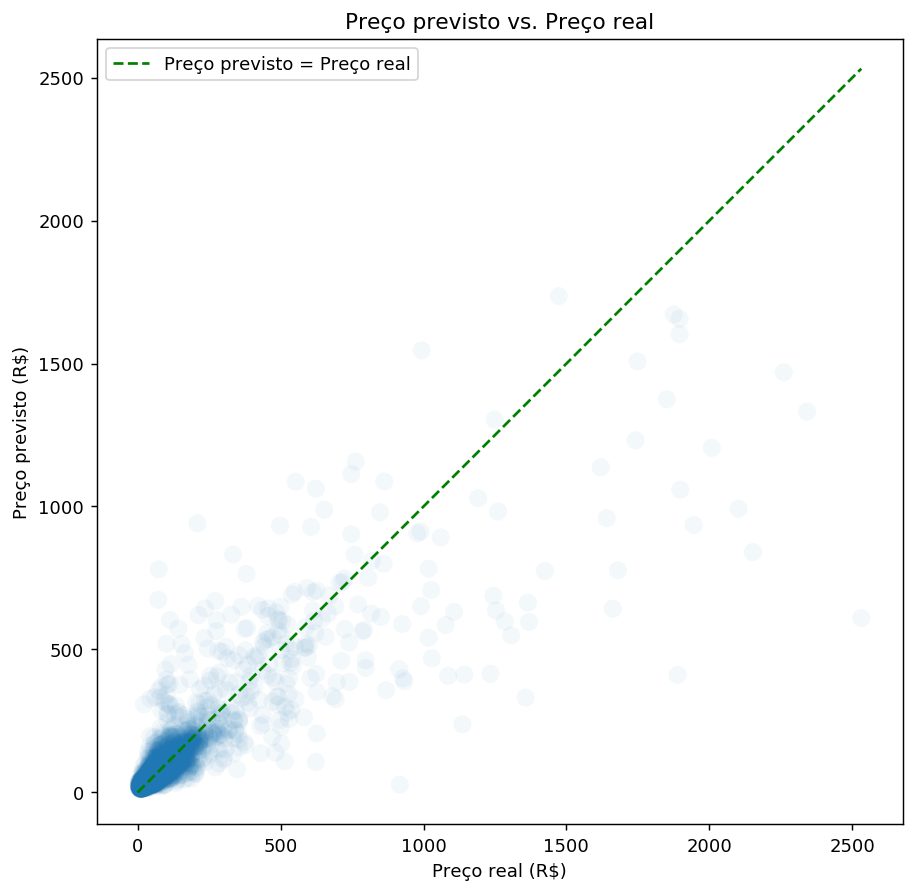

In [18]:
y_pred = shared_functions.get_all_predictions_from_splits(features, target, splits, estimators)                                                  
shared_functions.plot_splits_predicted_vs_real(target, y_pred)

### Mean absolute error

Now we can compare the errors obtained by our predictions against the errors provided by the baseline (average price). Our prediction errors should be less than the baseline errors to consider the model successful.

In [19]:
errors, errors_baseline, errors_relative, errors_baseline_relative, errors_baseline_median, errors_baseline_median_relative = shared_functions.print_mean_absolute_error(y_pred, target, average_target, median_target)

== Absolute
('Mean absolute prediction error: R$', 23.74)
('Std prediction error: R$', 75.74)
('Mean absolute error using average: R$', 61.83)
('Std prediction error using average: R$', 141.79)
('Mean absolute error using median: R$', 48.82)
('Std prediction error using median: R$', 150.9)
== Relative
('Mean relative absolute prediction error: ', 0.33)
('Std relative prediction error: ', 0.52)
('Mean relative absolute error using average: ', 1.4)
('Std relative prediction error using average: ', 1.55)
('Mean absolute error using median: R$', 0.6)
('Std prediction error using median: R$', 0.69)


### Join data

In [20]:
pd.set_option('display.max_columns', None)
predicted_df, joined_predicted_df = shared_functions.join_predicted_df(df, features, target, y_pred, errors, errors_relative, errors_baseline, errors_baseline_relative, errors_baseline_median, errors_baseline_median_relative)

### Worst absolute predictions

Below we can inspect the rows with the biggest prediction error.

In [21]:
joined_predicted_df.sort_values('error', ascending = False).head(20)

,all_features,error,error_baseline,error_baseline_median,error_baseline_median_relative,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4.565469e+08,"[456546893.0, 35306.3586902, 14.8179786868, 34...",1921.29444,2456.454754,2491.485,0.984360,0.970520,0.759084,609.77556,2531.07,1685,Complex Analysis Complex Analysis Complex Anal...,https://www.amazon.com.br/dp/0070006571/,"Lars V. Ahlfors (Autor),",Capa dura,McGraw-Hill Science/Engineering/Math,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0070006571,978-0070006577,Inglês,1,2531.07,35306.35869,345.000000,14.817979,4.449862,16.000000,23.100000,2.500000,427.519419,0.000085,13,0.000137
9.158984e+07,"[91589843.0, 311760.0, 14.8179786868, 545.0, 4...",1477.78392,1814.144754,1849.175,0.979042,0.960495,0.782410,410.97608,1888.76,1712,Vector Calculus,https://www.amazon.com.br/dp/1429215089/,"Jerrold E. Marsden (Autor),",Capa dura,W.H. Freeman & Company,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Análise Vetorial,NaN,NaN,NaN,NaN,1429215089,978-1429215084,Inglês,1,1888.76,311760.00000,545.000000,14.817979,4.449862,21.000000,26.000000,3.200000,427.519419,0.000095,13,0.000303
7.945218e+08,"[794521798.0, 35306.3586902, 14.8179786868, 76...",1311.61102,2077.554754,2112.585,0.981607,0.965330,0.609437,840.55898,2152.17,2199,Introduction to Chemical Engineering Thermodyn...,https://www.amazon.com.br/dp/1259696529/,J.M. Smith Termodinamica en ingenieria quimica...,Capa dura,McGraw-Hill Education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1259696529,978-1259696527,Inglês,1,2152.17,35306.35869,768.000000,14.817979,4.449862,18.500000,23.900000,3.300000,427.519419,0.000005,2,0.000325
1.144179e+09,"[1144179495.0, 35306.3586902, 14.8179786868, 4...",1109.90284,2026.924754,2061.955,0.981164,0.964495,0.528138,991.63716,2101.54,1991,Machine Learning,https://www.amazon.com.br/dp/0070428077/,"Tom M. Mitchell (Autor),",Capa dura,McGraw-Hill Science/Engineering/Math,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0070428077,978-0070428072,Inglês,1,2101.54,35306.35869,432.000000,14.817979,4.449862,16.800000,24.100000,3.300000,921.000000,0.000019,6,0.000538
1.993779e+09,"[1993779221.0, 35306.3586902, 14.8179786868, 3...",1025.49292,1282.384754,1317.415,0.970829,0.945015,0.755706,331.50708,1357.00,1716,A VULVA 2 Ed 2003,https://www.amazon.com.br/dp/8126532289/,S. M. Neill C. M. Ridley (Autor),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8126532289,978-8126532285,Inglês,1,1357.00,35306.35869,359.613815,14.817979,4.449862,15.282069,22.268796,2.107417,427.519419,0.000149,26,0.000361
1.895458e+09,"[1895458154.0, 35306.3586902, 14.8179786868, 4...",1019.24264,1586.864754,1621.895,0.976175,0.955091,0.613455,642.23736,1661.48,1897,A Transition to Advanced Mathematics,https://www.amazon.com.br/dp/1285463269/,"Douglas Smith (Autor),",Capa dura,Cengage Learning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1285463269,978-1285463261,Inglês,1,1661.48,35306.35869,448.000000,14.817979,4.449862,19.000000,23.500000,1.900000,748.000000,0.000061,9,0.000197
4.036193e+09,"[4036192844.0, 217838.0, 14.8179786868, 784.0,...",1009.57668,1870.304754,1905.335,0.979647,0.961636,0.519084,935.34332,1944.92,6610,Microeconomic Theory: Basic Principles and Ext...,https://www.amazon.com.br/dp/1305505794/,"Walter Nicholson (Autor),",Capa dura,Cengage Learning,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,"Administração, Negócios e Economia",Economia,Microeconomia,NaN,NaN,NaN,NaN,NaN,1305505794,978-1305505797,Inglês,1,1944.92,217838.00000,784.000000,14.817979,4.449862,21

### Worst relative predictions

In [22]:
joined_predicted_df.sort_values('error_relative', ascending = False).head(20)

,all_features,error,error_baseline,error_baseline_median,error_baseline_median_relative,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4.047607e+09,"[4047607377.0, 67771.0, 1.0, 136.0, 68.0, 8.6,...",285.88226,52.545246,17.515,0.793611,2.380845,12.953433,307.95226,22.07,9312,How to Win Friends & Influence People (Miniatu...,https://www.amazon.com.br/dp/0762462019/,Dale Carnegie (Autor),Capa dura,Running Press Miniature Editions,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,"Administração, Negócios e Economia",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0762462019,978-0762462018,Inglês,1,22.07,67771.00000,136.000000,1.000000,1.000000,7.300000,8.600000,1.600000,68.000000,0.001205,1,0.000000
2.272729e+08,"[227272911.0, 1451.0, 9.0, 368.0, 558.0, 22.8,...",33.83832,71.625246,36.595,12.239130,23.954932,11.317164,36.82832,2.99,5170,Caçadores de Obras-Primas,https://www.amazon.com.br/dp/8532526144/,Robert M. Edsel (Autor),Capa comum,Rocco,NaN,NaN,Livros,Livros,História,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8532526144,978-8532526144,Português,1,2.99,1451.00000,368.000000,9.000000,4.200000,15.800000,22.800000,2.000000,558.000000,0.000499,2,0.000213
2.644459e+09,"[2644458574.0, 35306.3586902, 14.8179786868, 3...",706.51142,1.015246,34.015,0.462160,0.013794,9.599340,780.11142,73.60,2169,100 Instructive Calculus-Based Physics Example...,https://www.amazon.com.br/dp/1941691137/,Chris McMullen (Autor),NaN,Zishka Publishing,NaN,17 de maio de 2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1941691137,978-1941691137,Inglês,1,73.60,35306.35869,359.613815,14.817979,4.449862,21.600000,27.900000,2.300000,980.000000,0.000199,16,0.000221
2.760304e+09,"[2760303957.0, 35306.3586902, 14.8179786868, 3...",601.65170,2.585246,32.445,0.450437,0.035891,8.352793,673.68170,72.03,1874,The Mathematics of Secrets – Cryptography from...,https://www.amazon.com.br/dp/0691183317/,Joshua Holden (Autor),Capa comum,Princeton University Press,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0691183317,978-0691183312,Inglês,1,72.03,35306.35869,392.000000,14.817979,4.449862,15.282069,22.268796,2.107417,667.000000,0.000143,15,0.000580
3.020829e+09,"[3020829397.0, 14037.0, 48.0, 60.0, 141.0, 22....",19.38734,71.715246,36.685,12.650000,24.729395,6.685290,22.28734,2.90,5084,Elevador 16,https://www.amazon.com.br/dp/8562409456/,Rodrigo De Oliveira (Autor),Capa comum,Faro,NaN,NaN,Livros,Livros,Literatura e Ficção,Literatura Infantojuvenil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8562409456,978-8562409455,Português,1,2.90,14037.00000,60.000000,48.000000,4.500000,15.600000,22.600000,0.600000,141.000000,0.000020,1,0.000000
4.254723e+09,"[4254722701.0, 22501.0, 14.8179786868, 240.0, ...",32.54402,69.615246,34.585,6.917000,13.923049,6.508804,37.54402,5.00,8487,Lacan com Derrida,https://www.amazon.com.br/dp/8520005926/,Rene Major (Autor),Capa comum,Civilização Brasileira,NaN,16 de outubro de 2002,Livros,Livros,Saúde e Família,Psicologia e Aconselhamento,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8520005926,978-8520005927,Português,1,5.00,22501.00000,240.000000,14.817979,4.449862,13.400000,20.800000,1.600000,340.000000,0.000042,1,0.000000
3.548407e+09,"[3548407309.0, 15302.0, 7.0, 1112.0, 427.51941...",283.06904,30.325246,4.705,0.106232,0.684697,6.391263,327.35904,44.29,9183,The Complete Fiction of H. P. Lovecraft,https://www.amazon.com.br/dp/0785834206/,H. P. Lovecraft (Autor),Capa dura,Chartwell Books,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Literatura e Ficção,Ficção,NaN,NaN,NaN,NaN,NaN,NaN,0785834206,978-0785834205,Inglês,1,44.29,15302.00000,1112.000000,7.000000,5.000000,17.800000,25.400000,5.100000,427.519419,0.000022,1,0.00000

### Best absolute predictions

In [23]:
joined_predicted_df.sort_values('error', ascending = True).head(20)

,all_features,error,error_baseline,error_baseline_median,error_baseline_median_relative,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.446279e+09,"[2446279264.0, 16846.0, 1.0, 176.0, 281.0, 22....",0.00024,41.715246,6.685,0.203191,1.267941,0.000007,32.90024,32.90,7701,De Magistro,https://www.amazon.com.br/dp/8594090013/,"Vários Autores (Autor),",Capa comum,Kírion,NaN,NaN,Livros,Livros,"Educação, Referência e Didáticos",Escolas e Ensino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8594090013,978-8594090010,Português,1,32.90,16846.0,176.0,1.000000,5.000000,15.6,22.8,1.0,281.000000,0.001245,4,0.000116
3.403065e+09,"[3403065037.0, 124.0, 40.0, 272.0, 540.0, 23.4...",0.00198,49.715246,14.685,0.589759,1.996596,0.000080,24.89802,24.90,3416,O Homem de Giz,https://www.amazon.com.br/dp/8551002937/,"C. J. Tudor (Autor),",Capa dura,Intrínseca,NaN,NaN,Livros,Livros,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8551002937,978-8551002933,Português,1,24.90,124.0,272.0,40.000000,4.300000,16.0,23.4,2.0,540.000000,0.004368,6,0.000498
3.742604e+09,"[3742604352.0, 9060.0, 14.8179786868, 304.0, 4...",0.00696,56.625246,21.595,1.200389,3.147596,0.000387,17.99696,17.99,3816,Trilha Sonora Para o Fim dos Tempos,https://www.amazon.com.br/dp/8551003089/,Marra Anthony (Autor),Capa comum,Intrínseca,NaN,NaN,Livros,Livros,"Fantasia, Horror e Ficção Científica",Fantasia,Coleções e Antologias,NaN,NaN,NaN,NaN,NaN,NaN,8551003089,978-8551003084,Português,1,17.99,9060.0,304.0,14.817979,4.449862,16.0,23.0,1.5,422.000000,0.006641,4,0.000654
2.749568e+06,"[2749568.0, 70091.0, 14.8179786868, 392.0, 431...",0.01164,31.725246,3.305,0.077058,0.739689,0.000271,42.87836,42.89,8329,Traição,https://www.amazon.com.br/dp/8535912312/,Ronaldo Vainfas (Autor),Capa comum,Companhia das Letras,NaN,NaN,Livros,Livros,História,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8535912312,978-8535912319,Português,1,42.89,70091.0,392.0,14.817979,4.449862,14.0,20.8,2.2,431.000000,0.000045,1,0.000000
3.647502e+07,"[36475016.0, 13338.0, 5.0, 224.0, 399.0, 17.8,...",0.01378,44.715246,9.685,0.323913,1.495493,0.000461,29.91378,29.90,3327,Leites e Manteigas Vegetais. Receitas Caseiras,https://www.amazon.com.br/dp/8578813553/,"Melissa M. King (Autor),",Capa comum,Alaúde,NaN,NaN,Livros,Livros,Gastronomia e Culinária,Natural e Vegetariana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8578813553,978-8578813550,Português,1,29.90,13338.0,224.0,5.000000,3.900000,16.2,17.8,1.4,399.000000,0.000035,1,0.000000
1.458887e+09,"[1458887206.0, 12018.0, 4.0, 648.0, 862.0, 20....",0.01540,7.315246,27.715,0.411813,0.108696,0.000229,67.28460,67.30,222,Órganon - Coleção Obras Completas,https://www.amazon.com.br/dp/8572838953/,Aristoteles (Autor),Capa comum,Edipro,NaN,NaN,Livros,Livros,"Política, Filosofia e Ciências Sociais",Filosofia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8572838953,978-8572838955,Português,1,67.30,12018.0,648.0,4.000000,3.600000,13.4,20.8,3.6,862.000000,0.012440,107,0.009838
5.922167e+08,"[592216690.0, 28911.0, 1.0, 128.0, 281.0, 23.8...",0.01820,39.575246,4.545,0.129709,1.129431,0.000519,35.05820,35.04,6640,Introdução ao Estudo das Relações Internacionais,https://www.amazon.com.br/dp/8502199684/,"Thiago Gehre (Autor),",Capa comum,Saraiva,NaN,NaN,Livros,Livros,"Política, Filosofia e Ciências Sociais",Ciências Sociais,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8502199684,978-8502199682,Português,1,35.04,28911.0,128.0,1.000000,5.000000,16.8,23.8,1.0,281.000000,0.000089,2,0.000144
1.468508e+09,"[1468508099.0, 12068.0, 14.8179786868, 112.0, ...",0.02130,54.865246,19.835,1.004304,2.777987,0.001078,19.77130,19.75,2807,A Cultura Literária Medieval,https://www.amazon.com.br/dp/8574803405/,Segis

### Best relative predictions

In [24]:
joined_predicted_df.sort_values('error', ascending = True).head(20)

,all_features,error,error_baseline,error_baseline_median,error_baseline_median_relative,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.446279e+09,"[2446279264.0, 16846.0, 1.0, 176.0, 281.0, 22....",0.00024,41.715246,6.685,0.203191,1.267941,0.000007,32.90024,32.90,7701,De Magistro,https://www.amazon.com.br/dp/8594090013/,"Vários Autores (Autor),",Capa comum,Kírion,NaN,NaN,Livros,Livros,"Educação, Referência e Didáticos",Escolas e Ensino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8594090013,978-8594090010,Português,1,32.90,16846.0,176.0,1.000000,5.000000,15.6,22.8,1.0,281.000000,0.001245,4,0.000116
3.403065e+09,"[3403065037.0, 124.0, 40.0, 272.0, 540.0, 23.4...",0.00198,49.715246,14.685,0.589759,1.996596,0.000080,24.89802,24.90,3416,O Homem de Giz,https://www.amazon.com.br/dp/8551002937/,"C. J. Tudor (Autor),",Capa dura,Intrínseca,NaN,NaN,Livros,Livros,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8551002937,978-8551002933,Português,1,24.90,124.0,272.0,40.000000,4.300000,16.0,23.4,2.0,540.000000,0.004368,6,0.000498
3.742604e+09,"[3742604352.0, 9060.0, 14.8179786868, 304.0, 4...",0.00696,56.625246,21.595,1.200389,3.147596,0.000387,17.99696,17.99,3816,Trilha Sonora Para o Fim dos Tempos,https://www.amazon.com.br/dp/8551003089/,Marra Anthony (Autor),Capa comum,Intrínseca,NaN,NaN,Livros,Livros,"Fantasia, Horror e Ficção Científica",Fantasia,Coleções e Antologias,NaN,NaN,NaN,NaN,NaN,NaN,8551003089,978-8551003084,Português,1,17.99,9060.0,304.0,14.817979,4.449862,16.0,23.0,1.5,422.000000,0.006641,4,0.000654
2.749568e+06,"[2749568.0, 70091.0, 14.8179786868, 392.0, 431...",0.01164,31.725246,3.305,0.077058,0.739689,0.000271,42.87836,42.89,8329,Traição,https://www.amazon.com.br/dp/8535912312/,Ronaldo Vainfas (Autor),Capa comum,Companhia das Letras,NaN,NaN,Livros,Livros,História,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8535912312,978-8535912319,Português,1,42.89,70091.0,392.0,14.817979,4.449862,14.0,20.8,2.2,431.000000,0.000045,1,0.000000
3.647502e+07,"[36475016.0, 13338.0, 5.0, 224.0, 399.0, 17.8,...",0.01378,44.715246,9.685,0.323913,1.495493,0.000461,29.91378,29.90,3327,Leites e Manteigas Vegetais. Receitas Caseiras,https://www.amazon.com.br/dp/8578813553/,"Melissa M. King (Autor),",Capa comum,Alaúde,NaN,NaN,Livros,Livros,Gastronomia e Culinária,Natural e Vegetariana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8578813553,978-8578813550,Português,1,29.90,13338.0,224.0,5.000000,3.900000,16.2,17.8,1.4,399.000000,0.000035,1,0.000000
1.458887e+09,"[1458887206.0, 12018.0, 4.0, 648.0, 862.0, 20....",0.01540,7.315246,27.715,0.411813,0.108696,0.000229,67.28460,67.30,222,Órganon - Coleção Obras Completas,https://www.amazon.com.br/dp/8572838953/,Aristoteles (Autor),Capa comum,Edipro,NaN,NaN,Livros,Livros,"Política, Filosofia e Ciências Sociais",Filosofia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8572838953,978-8572838955,Português,1,67.30,12018.0,648.0,4.000000,3.600000,13.4,20.8,3.6,862.000000,0.012440,107,0.009838
5.922167e+08,"[592216690.0, 28911.0, 1.0, 128.0, 281.0, 23.8...",0.01820,39.575246,4.545,0.129709,1.129431,0.000519,35.05820,35.04,6640,Introdução ao Estudo das Relações Internacionais,https://www.amazon.com.br/dp/8502199684/,"Thiago Gehre (Autor),",Capa comum,Saraiva,NaN,NaN,Livros,Livros,"Política, Filosofia e Ciências Sociais",Ciências Sociais,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8502199684,978-8502199682,Português,1,35.04,28911.0,128.0,1.000000,5.000000,16.8,23.8,1.0,281.000000,0.000089,2,0.000144
1.468508e+09,"[1468508099.0, 12068.0, 14.8179786868, 112.0, ...",0.02130,54.865246,19.835,1.004304,2.777987,0.001078,19.77130,19.75,2807,A Cultura Literária Medieval,https://www.amazon.com.br/dp/8574803405/,Segis

### Relative errors distribution

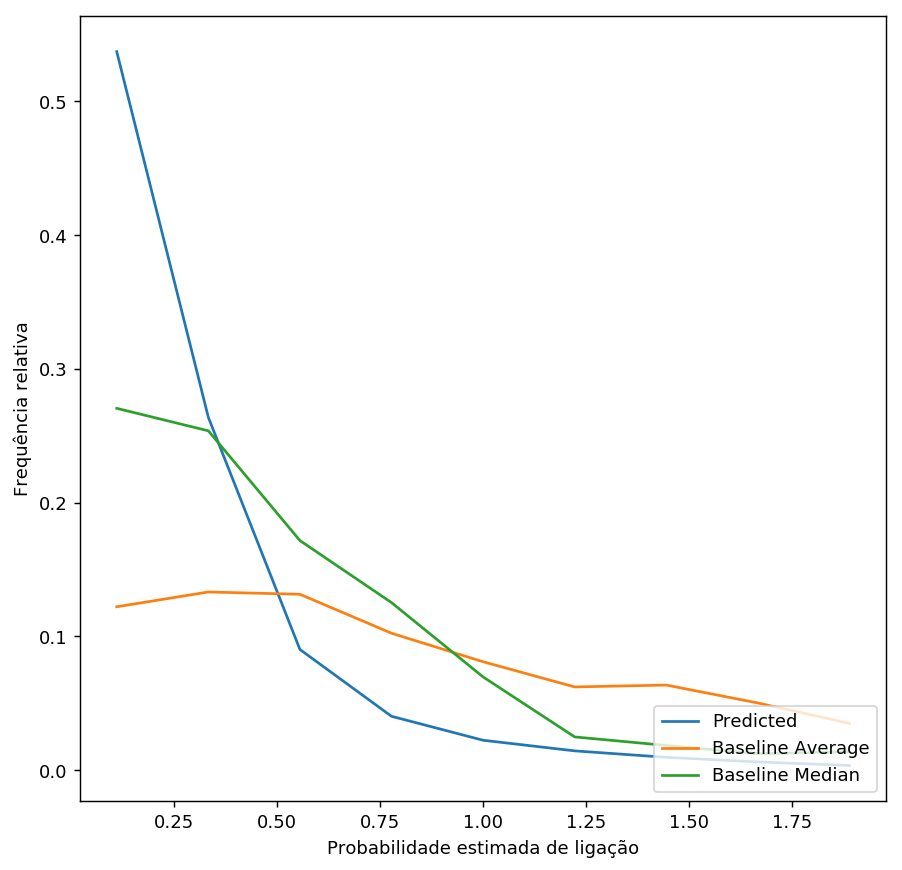

In [25]:
centers, normalized_hist_predicted, normalized_hist_baseline, normalized_hist_baseline_median = shared_functions.plot_relative_error_distribution(predicted_df)

#### Accumulated

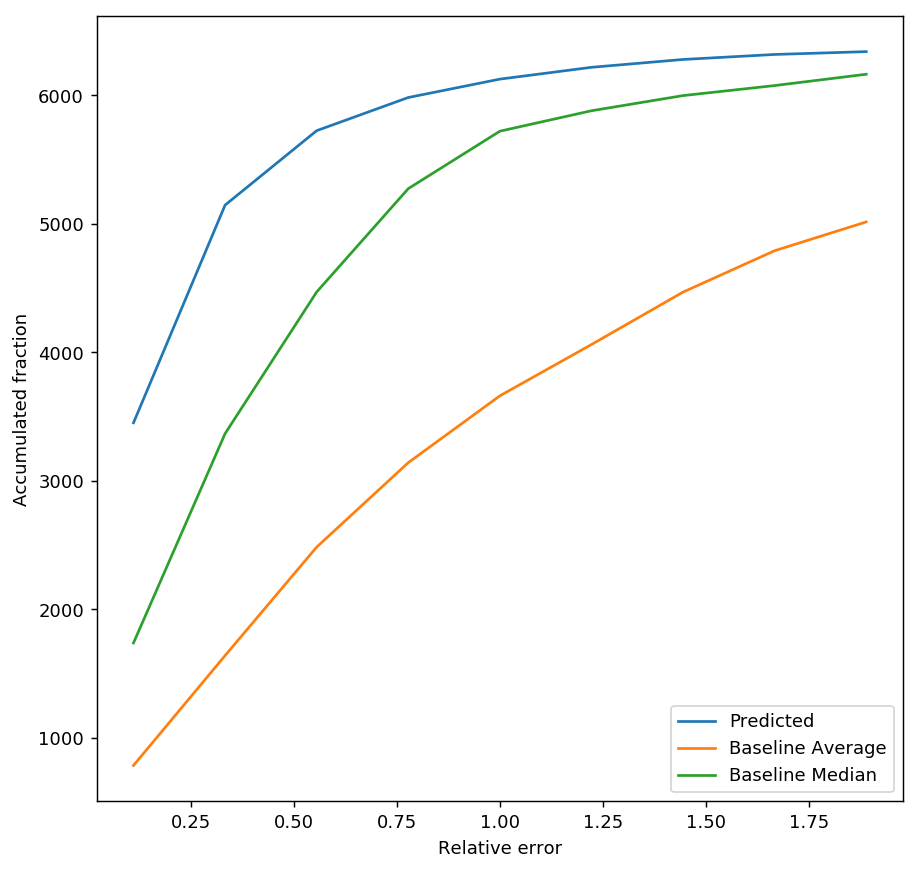

In [26]:
shared_functions.plot_accumulated_relative_error(centers, normalized_hist_predicted, normalized_hist_baseline, normalized_hist_baseline_median)

### Joined data summary

In [27]:
joined_predicted_df.describe(percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99])

,error,error_baseline,error_baseline_median,error_baseline_median_relative,error_baseline_relative,error_relative,prediction,target,id,edition,category8,category9,category10,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
count,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,0.0,0.0,0.0,0.0,6422.0,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6.422000e+03,6422.000000,6422.000000
mean,23.743310,61.827255,48.822761,0.598230,1.398773,0.332481,71.012138,74.615246,4740.627998,NaN,NaN,NaN,NaN,1.0,74.615246,34396.837435,356.517123,14.722555,4.445179,15.269786,22.256914,2.097243,426.894244,3.046727e-03,10.414668,0.001053
std,75.748026,141.804791,150.914147,0.694263,1.555082,0.517193,120.707864,154.699074,2836.864842,NaN,NaN,NaN,NaN,0.0,154.699074,47028.765946,253.833058,33.749898,0.558813,2.595906,2.594850,1.224698,202.259949,1.051285e-02,22.699278,0.002902
min,0.000240,0.004754,0.015000,0.000379,0.000064,0.000007,10.828900,2.900000,1.000000,NaN,NaN,NaN,NaN,1.0,2.900000,5.000000,2.000000,1.000000,1.000000,0.800000,8.600000,0.200000,4.500000,4.839274e-09,1.000000,0.000000
25%,3.697760,26.284754,8.007500,0.203191,0.437673,0.094923,29.070405,26.600000,2295.250000,NaN,NaN,NaN,NaN,1.0,26.600000,7734.750000,196.000000,2.000000,4.400000,13.600000,20.800000,1.300000,281.000000,3.044894e-05,1.000000,0.000000
50%,8.343350,41.415246,16.190000,0.418817,0.918130,0.204741,38.519370,39.585000,4676.500000,NaN,NaN,NaN,NaN,1.0,39.585000,21151.000000,304.000000,9.000000,4.449862,15.400000,22.600000,1.800000,427.519419,2.377993e-04,3.000000,0.000232
75%,17.270825,53.615246,28.595000,0.751382,1.805084,0.375430,60.646480,63.680000,7251.500000,NaN,NaN,NaN,NaN,1.0,63.680000,41861.250000,432.000000,14.817979,4.900000,16.000000,23.200000,2.600000,525.000000,1.509252e-03,9.000000,0.000787
85%,26.857034,59.715246,53.187000,0.942841,2.569340,0.537925,90.515004,92.772000,8197.850000,NaN,NaN,NaN,NaN,1.0,92.772000,59477.550000,548.850000,14.817979,5.000000,17.000000,23.900000,3.000000,640.000000,3.740398e-03,16.000000,0.001490
90%,39.404996,64.715246,85.278000,1.200389,3.147596,0.711154,120.039802,124.863000,8723.800000,NaN,NaN,NaN,NaN,1.0,124.863000,75537.900000,632.000000,21.900000,5.000000,18.900000,25.300000,3.400000,721.000000,6.475211e-03,25.000000,0.002382
95%,73.594828,130.926754,165.957000,1.829521,4.333470,1.067626,200.886338,205.542000,9205.950000,NaN,NaN,NaN,NaN,1.0,205.542000,107765.650000,800.000000,44.000000,5.000000,20.800000,27.600000,4.200000,821.000000,1.638451e-02,47.000000,0.004870


### Visualize decision tree

In [29]:
shared_functions.render_image_first_decision_tree(rf, feature_list, 'tree-price.png')

Output image:  tree-price.png


<img src="files/image.png">